# Exploratory Analysis and Fairness Metrics

## 1. Context

**Dataset:** Predict Students' Dropout and Academic Success

Our dataset was created by a higher education institution made from several disjoint datasets to predict a student's dropout and academic success. Each instance is a unique student and the information was presumably gathered from when they applied to the institution. The dataset was created to identify students at risk of dropping out in order to give them the support they need to succeed.




In [614]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
df = pd.read_csv('data.csv', delimiter=';')
df = df[df['Target'] != 'Enrolled']
columns_to_keep = [
    'Gender',
    'Target',
    'Marital status',
    'Application mode',
    'Previous qualification',
    'Previous qualification (grade)',
    "Mother's qualification",
    "Father's qualification",
    'Admission grade',
    'Scholarship holder',
    'Age at enrollment',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (grade)',
    'Tuition fees up to date'
]

df = df[columns_to_keep]

label = 'Target'
sensitive_attr = 'Gender'

Sensitive Attribute: Gender
1: male, 0: Female

**Encode the target:**

Graduate = 1 \\
Dropout = 0

In [615]:
le_target = LabelEncoder()

df['Target_encoded'] = le_target.fit_transform(df['Target'])
df.drop('Target', axis=1, inplace=True)

## 2. Code: Accuracy and Fairness Metrics

**Train the Baseline:**

In [616]:
X = df.drop('Target_encoded', axis=1)
y = df['Target_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.844


**Fairness Metrics Reported:**

- **Equal Opportunity**
   
   To calculate our Equal Opportunity Disparity, we need to find TPRs for each gender.


In [617]:
df_eop = X_test.copy()
df_eop['y_test'] = y_test
df_eop['y_pred'] = y_pred

tpr_genders = {}
for gender in df_eop['Gender'].unique():
    df_gender = df_eop['Gender'] == gender
    tpr = df_eop[df_gender & (df_eop['y_test'] == 1)]['y_test'].count() / df_eop[df_gender]['y_test'].count()
    tpr_genders[gender] = tpr

print("True Positive Rates by Gender:")
for gender, tpr in tpr_genders.items():
    print(f"{gender}: {tpr:.3f}")

tpr_vals = list(tpr_genders.values())
eo_disparity = max(tpr_vals) - min(tpr_vals)

print(f"Equal Opportunity Disparity: {eo_disparity:.3f}")

True Positive Rates by Gender:
0: 0.704
1: 0.457
Equal Opportunity Disparity: 0.247


We find that Female students have a significantly higher TPR than male students, meaning that the model is better at predicting a positive outcome (Graduation), for female students compared to males.



- **Equalized Odds**

In [618]:
df_eod = X_test.copy()
df_eod['y_true'] = y_test
df_eod['y_pred'] = y_pred

tpr_fpr_genders = {}

for gender in df_eod['Gender'].unique():
    mask = df_eod['Gender'] == gender
    y_true_group = df_eod[mask]['y_true']
    y_pred_group = df_eod[mask]['y_pred']

    tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group).ravel()

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    tpr_fpr_genders[gender] = {'TPR': tpr, 'FPR': fpr}

print("Equalized Odds Metrics by Gender:")
for gender, metrics in tpr_fpr_genders.items():
    print(f"{gender}: TPR = {metrics['TPR']:.3f}, FPR = {metrics['FPR']:.3f}")

tpr_values = [metrics['TPR'] for metrics in tpr_fpr_genders.values()]
fpr_values = [metrics['FPR'] for metrics in tpr_fpr_genders.values()]
tpr_disparity = max(tpr_values) - min(tpr_values)
fpr_disparity = max(fpr_values) - min(fpr_values)

print(f"Equalized Odds Disparities: TPR Disparity = {tpr_disparity:.3f}, FPR Disparity = {fpr_disparity:.3f}")

Equalized Odds Metrics by Gender:
0: TPR = 0.972, FPR = 0.349
1: TPR = 0.888, FPR = 0.312
Equalized Odds Disparities: TPR Disparity = 0.084, FPR Disparity = 0.037


Calculating our Equalized Odds Disparity gives us an interesting result. When comparing both TPRs and FPRs from both genders, the classifier performs relatively fairly. Since the disparity here is significantly lower, we should focus more on balancing Equal Opportunity.

## 3. Discussion: Relevant Fairness Metrics


The fairness metrics we use for this model are **Equal Opportunity** and **Equalized Odds**. We use Equal Opportunity to ensure that students who are actually at risk of dropping out are identified at equal rates across different genders. We also want to ensure that TPRs and FPRs for both male and female students are similar so we also use Equalized Odds. This is important because we can balance both intervention and over-penalization. We ignore other fairness metrics like Demographic Parity because Demographic Parity would likely artificially inflate or deflate dropout predictions, ignoring potentially important external factors. We don't use Accuracy Parity because it may focus on improving the performance of the classifier at the cost of some fairness.

## 4. Code: Unfairness in the Dataset

In [619]:
df_male = df[df['Gender'] == 1]
df_female = df[df['Gender'] == 0]

print(f"Percentage of Female Students in dataset {len(df_female)/len(df):.3f}")

female_graduate_count = (df_female['Target_encoded'] == 1).sum()

print(f"Percentage of Female Graduate {(female_graduate_count/len(df_female)):.3f}")

male_graduate_count = (df_male['Target_encoded'] == 1).sum()

print(f"Percentage of Male Graduate {(male_graduate_count/len(df_male)):.3f}")


Percentage of Female Students in dataset 0.656
Percentage of Female Graduate 0.698
Percentage of Male Graduate 0.439


We see that in the dataset that there are more females in the dataset than males however we do not think that it would make a big enough difference. However we did see that females had a way higher graduation rate than males do, (About 26% greater) and we think this may be the cause to the disparity with the two genders.

In [620]:
test_x_train_df = X_train
test_y_train_df = y_train

df_female_dropout = df[(df['Gender'] == 0) & (df['Target_encoded'] == 0)]
num_new_samples = int(len(df_female_dropout) * 0.5)

df_synthetic = df_female_dropout.sample(n=num_new_samples, replace=True).reset_index(drop=True)

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    df_synthetic[col] += np.random.normal(0, 0.1, size=len(df_synthetic))  

X_synthetic = df_synthetic.drop(columns=['Target_encoded'])
y_synthetic = df_synthetic['Target_encoded']

test_x_train_df = pd.concat([test_x_train_df, X_synthetic], ignore_index=True)
test_y_train_df = pd.concat([test_y_train_df, y_synthetic], ignore_index=True)

new_model = LogisticRegression(max_iter=2000)
new_model.fit(test_x_train_df, test_y_train_df)
y_pred_new = new_model.predict(X_test)

accuracy = new_model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.3f}")



Accuracy: 0.839


In [621]:
df_eop = X_test.copy()
df_eop['y_test'] = y_test
df_eop['y_pred'] = y_pred_new

tpr_genders = {}

for gender in df_eop['Gender'].unique():
    mask = df_eop['Gender'] == gender
    y_true_group = df_eop[mask]['y_test']
    y_pred_group = df_eop[mask]['y_pred']

    tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group).ravel()

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tpr_genders[gender] = tpr

print("True Positive Rates by Gender:")
for gender, tpr in tpr_genders.items():
    print(f"{gender}: {tpr:.3f}")

tpr_vals = list(tpr_genders.values())
eo_disparity = max(tpr_vals) - min(tpr_vals)

print(f"Equal Opportunity Disparity: {eo_disparity:.3f}")

True Positive Rates by Gender:
0: 0.937
1: 0.888
Equal Opportunity Disparity: 0.048


After adding synthetic data to increase the amount of female dropouts in the training set, our equal opportunity disparity got a lot smaller while keeping the accuracy relatively the same (Only <1% loss).

## 5. Code: Different Modeling Choices

We can add different weights to each gender to change our model to become more fair. Below we added more weight to male students when we train our model.

In [622]:
from sklearn.utils.class_weight import compute_class_weight

custom_weights = {
    0: 1.0,  # Females
    1: 2.0   # Males
}

weighted_model = LogisticRegression(max_iter=2000, class_weight=custom_weights)
weighted_model.fit(X_train, y_train)
weighted_y_pred = weighted_model.predict(X_test)

accuracy = weighted_model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.3f}")


Accuracy: 0.835


In [623]:
df_eop = X_test.copy()
df_eop['y_test'] = y_test
df_eop['y_pred'] = weighted_y_pred

tpr_genders = {}

for gender in df_eop['Gender'].unique():
    mask = df_eop['Gender'] == gender
    y_true_group = df_eop[mask]['y_test']
    y_pred_group = df_eop[mask]['y_pred']

    tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group).ravel()

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tpr_genders[gender] = tpr

print("True Positive Rates by Gender:")
for gender, tpr in tpr_genders.items():
    print(f"{gender}: {tpr:.3f}")

tpr_vals = list(tpr_genders.values())
eo_disparity = max(tpr_vals) - min(tpr_vals)

print(f"Equal Opportunity Disparity: {eo_disparity:.3f}")

True Positive Rates by Gender:
0: 0.988
1: 0.924
Equal Opportunity Disparity: 0.065


Here we can see while we lose accuracy by 1%, we can see that the fairness is greatly improved as the TPR are more similar.

## 6. Code: Post-processing

We can change female predicted graduates to dropout so that we can offer support to more female students that may be struggling with their studies.

In [624]:
df_predictions = X_test.copy()
df_predictions['y_pred'] = y_pred
df_predictions['y_test'] = y_test

female_predicted_graduates = df_predictions[
    (df_predictions['Gender'] == 0) & (df_predictions['y_pred'] == 1)
]

In [625]:
from sklearn.metrics import accuracy_score

threshold = df_predictions['Admission grade'].quantile(0.15)

low_grade_females = female_predicted_graduates[female_predicted_graduates['Admission grade'] < threshold]

df_predictions.loc[low_grade_females.index, 'y_pred'] = 0

accuracy_modified = accuracy_score(df_predictions['y_test'], df_predictions['y_pred'])

print(f"Modified Model Accuracy: {accuracy_modified:.3f}")

Modified Model Accuracy: 0.802


In [626]:
df_eop = X_test.copy()
df_eop['y_test'] = y_test
df_eop['y_pred'] = df_predictions['y_pred']

tpr_genders = {}

for gender in df_eop['Gender'].unique():
    mask = df_eop['Gender'] == gender
    y_true_group = df_eop[mask]['y_test']
    y_pred_group = df_eop[mask]['y_pred']

    tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group).ravel()

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tpr_genders[gender] = tpr

print("True Positive Rates by Gender:")
for gender, tpr in tpr_genders.items():
    print(f"{gender}: {tpr:.3f}")

tpr_vals = list(tpr_genders.values())
eo_disparity = max(tpr_vals) - min(tpr_vals)

print(f"Equal Opportunity Disparity: {eo_disparity:.3f}")

True Positive Rates by Gender:
0: 0.863
1: 0.888
Equal Opportunity Disparity: 0.025


Here we filter all females predicted to graduate. Then we located the bottom **15%** of all the students based on their admission grade and if they are a female previously predicted as graduate we flip to them dropout so we can identify female students that may need additional support. Here we can see TPR is very similar for both groups but our accuracy drops a fair bit (about 4%). Depending on our goals this would be acceptable like in the case where we need to find students that would have a higher chance of needing additional support.

## 7. Intervention Discussion

As a team we discussed that **in-processing** or **post-processing** techniques may be more appropriate to improve equal opportunity as it seems more reasonable to add more weight to different gender groups or pulling female students that have lower admission grades in order to offer them additional support. We thought that fabricating data and adding synthetic female students into our dataset doesn't seem right even though it offered us the highest accuracy between the different processing methods.

As we can see, all of our processing techniques caused us to have lower accuracy in determining graduate or dropout students but this is to be expected. The lowest drop in accuracy was our post-processing method which gave us an accuracy of 80% which was a 4% drop in accuracy compared to the base model without any fairness enforcement.

## Other Research

## 8. Context: *A Convex Framework for Fair Regression*

**A Convex Framework for Fair Regression**

Main Topic Points
- Fairness Regularizers for Regression
    - Introduction to a fairness regularizer to compute the *Pareto Curve* which allows those to analyze the trade-off between the fairness and performance of a model to make informed decisions based on the users goals

- **"Price of Fairness" (PoF)**
    - Numerical quantifying unit to show how much a model's accuracy is reduced when using fairness constraints

- Comparing different Fairness implementations
    - They compare fairness for **different groups** of people as well as tracking **individual fairness** or looking at different individuals with similar outcomes

The paper talks about different fairness implementations and their individual constraints. It also gives us a way to **measure the effect of fairness implementations on the model's accuracy** so users can choose which methodology to follow when introducing fairness into their models based on their goals. They also talk about how fairness trade offs are **"highly domain-specific"** reinforcing the importance of using metrics like PoF to determine how fairness should be used in our predictors.

## 9. Code: Fairness Regularizer and PoF Implementation

In [ ]:
df = pd.read_csv('data.csv', delimiter=';')
df = df[df['Target'] != 'Enrolled']
columns_to_keep = [
    'Gender',
    'Target',
    'Marital status',
    'Application mode',
    'Previous qualification',
    'Previous qualification (grade)',
    "Mother's qualification",
    "Father's qualification",
    'Admission grade',
    'Scholarship holder',
    'Age at enrollment',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (grade)',
    'Tuition fees up to date',
    'International'
]

df = df[columns_to_keep]

label = 'Target'
sensitive_attr = 'Gender'

le_target = LabelEncoder()

df['Target_encoded'] = le_target.fit_transform(df['Target'])
df.drop('Target', axis=1, inplace=True)

X = df.drop('Target_encoded', axis=1)
y = df['Target_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.839


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class FairLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, fairness_weight=0.0, max_iter=2000):
        self.fairness_weight = fairness_weight
        self.model = LogisticRegression(max_iter=max_iter)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def fairness_loss(self, X, y):
        y_pred = self.predict(X)
        df_eval = X.copy()
        df_eval['y_true'] = y
        df_eval['y_pred'] = y_pred

        tpr_gender = {}
        for gender in df_eval['Gender'].unique():
            mask = df_eval['Gender'] == gender
            y_true_group = df_eval[mask]['y_true']
            y_pred_group = df_eval[mask]['y_pred']
            tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group).ravel()
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            tpr_gender[gender] = tpr


        tpr_values = list(tpr_gender.values())
        tpr_disparity = max(tpr_values) - min(tpr_values)

        return self.fairness_weight * tpr_disparity

    def score(self, X, y):
        base_accuracy = self.model.score(X, y)
        fairness_penalty = self.fairness_loss(X, y)
        return base_accuracy - fairness_penalty

In [643]:
fairness_weights = np.linspace(0, 7, num=20)
accuracy_results = []
fairness_results = []

for weight in fairness_weights:
    fair_model = FairLogisticRegression(fairness_weight=weight)
    fair_model.fit(X_train, y_train)
    accuracy = fair_model.score(X_test, y_test)
    fairness_penalty = fair_model.fairness_loss(X_test, y_test)

    accuracy_results.append(accuracy)
    fairness_results.append(fairness_penalty)

    print(f"Fairness Weight: {weight} | Accuracy: {accuracy:.3f} | TPR Disparity: {fairness_penalty:.3f}")

Fairness Weight: 0.0 | Accuracy: 0.839 | TPR Disparity: 0.000
Fairness Weight: 0.3684210526315789 | Accuracy: 0.800 | TPR Disparity: 0.039
Fairness Weight: 0.7368421052631579 | Accuracy: 0.761 | TPR Disparity: 0.078
Fairness Weight: 1.1052631578947367 | Accuracy: 0.722 | TPR Disparity: 0.117
Fairness Weight: 1.4736842105263157 | Accuracy: 0.683 | TPR Disparity: 0.156
Fairness Weight: 1.8421052631578947 | Accuracy: 0.644 | TPR Disparity: 0.195
Fairness Weight: 2.2105263157894735 | Accuracy: 0.605 | TPR Disparity: 0.234
Fairness Weight: 2.5789473684210527 | Accuracy: 0.566 | TPR Disparity: 0.274
Fairness Weight: 2.9473684210526314 | Accuracy: 0.527 | TPR Disparity: 0.313
Fairness Weight: 3.31578947368421 | Accuracy: 0.488 | TPR Disparity: 0.352
Fairness Weight: 3.6842105263157894 | Accuracy: 0.449 | TPR Disparity: 0.391
Fairness Weight: 4.052631578947368 | Accuracy: 0.409 | TPR Disparity: 0.430
Fairness Weight: 4.421052631578947 | Accuracy: 0.370 | TPR Disparity: 0.469
Fairness Weight: 4

In [ ]:
baseline_accuracy = accuracy_results[0]
pof_results = [acc / baseline_accuracy for acc in accuracy_results]

print("\nPrice of Fairness (PoF) Analysis:")
for weight, pof in zip(fairness_weights, pof_results):
    print(f"Fairness Weight: {weight} | PoF: {pof:.3f}")


Price of Fairness (PoF) Analysis:
Fairness Weight: 0.0 | PoF: 1.000
Fairness Weight: 0.3684210526315789 | PoF: 0.953
Fairness Weight: 0.7368421052631579 | PoF: 0.907
Fairness Weight: 1.1052631578947367 | PoF: 0.860
Fairness Weight: 1.4736842105263157 | PoF: 0.814
Fairness Weight: 1.8421052631578947 | PoF: 0.767
Fairness Weight: 2.2105263157894735 | PoF: 0.721
Fairness Weight: 2.5789473684210527 | PoF: 0.674
Fairness Weight: 2.9473684210526314 | PoF: 0.628
Fairness Weight: 3.31578947368421 | PoF: 0.581
Fairness Weight: 3.6842105263157894 | PoF: 0.534
Fairness Weight: 4.052631578947368 | PoF: 0.488
Fairness Weight: 4.421052631578947 | PoF: 0.441
Fairness Weight: 4.789473684210526 | PoF: 0.395
Fairness Weight: 5.157894736842105 | PoF: 0.348
Fairness Weight: 5.526315789473684 | PoF: 0.302
Fairness Weight: 5.894736842105263 | PoF: 0.255
Fairness Weight: 6.263157894736842 | PoF: 0.209
Fairness Weight: 6.63157894736842 | PoF: 0.162
Fairness Weight: 7.0 | PoF: 0.115


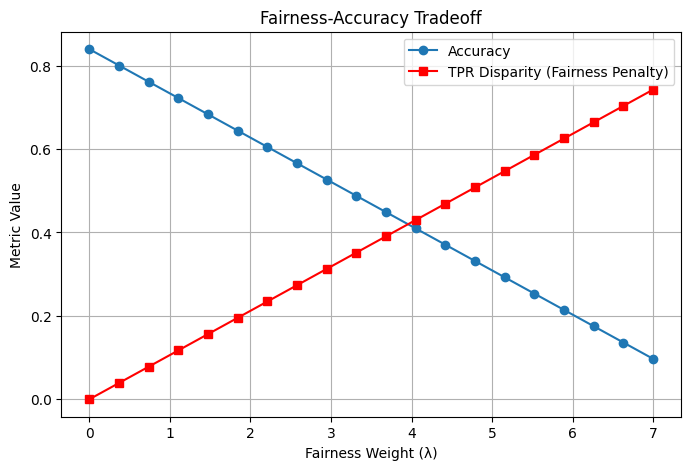

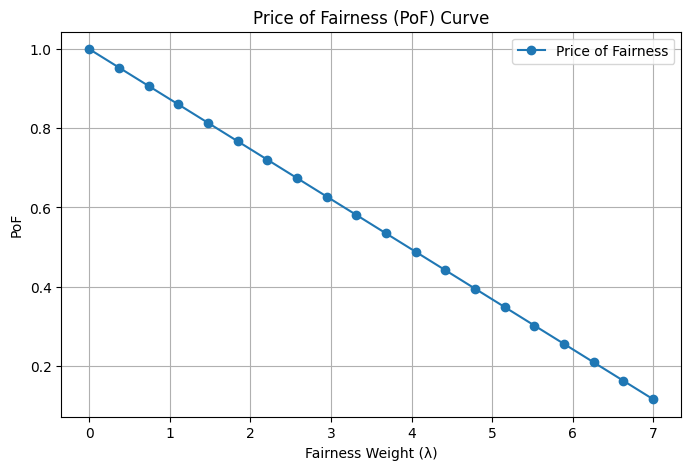

In [647]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(fairness_weights, accuracy_results, marker='o', label='Accuracy')
plt.plot(fairness_weights, fairness_results, marker='s', label='TPR Disparity (Fairness Penalty)', color='red')
plt.xlabel("Fairness Weight (λ)")
plt.ylabel("Metric Value")
plt.title("Fairness-Accuracy Tradeoff")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(fairness_weights, pof_results, marker='o', label='Price of Fairness')
plt.xlabel("Fairness Weight (λ)")
plt.ylabel("PoF")
plt.title("Price of Fairness (PoF) Curve")
plt.legend()
plt.grid()
plt.show()

## 10. Discussion: Research Paper Implementations

In the graphs above we saw that fairness weight and the price of fairness was linear which means as it got more and more fair accuracy also dropped so it no matter what the fairness weight was the accuracy dropped. We didn't really learn any new information from this as the fairness weights did not help us at all as it decreased our accuracy a lot while not getting us much closer group tpr values. Although the PoF and Fairness / Accuracy plots were very nice visually, we found it more efficient to implement our own fairness metrics.